# Import Packages

In [1]:
from astropy.io import fits
from astropy.time import Time
from astropy.table import Table
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from radvel.utils import timebin # needed for timebinning

/Users/howard/opt/anaconda3/lib/python3.9/site-packages/autograd/numpy/numpy_wrapper.py:21: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  int_types = {_np.int, _np.int8, _np.int16, _np.int32, _np.int64, _np.integer}


# Define Directories and Filenames
One needs to have the L2 files kusted bekiw in the data directory of the folder from which this notebook is running.  This file can be downloaded from Jump or shrek.caltech.edu.  One can also modify the code below to work with other files or paths.  The example below is a ~1.5-hour time series on Tau Ceti (HD 10700).

In [2]:
L2_data_dir = '/Users/howard/temp/kpf/L2/20230110/'

# Time series of observations of 10700 (Tau Ceti) from Jan. 10, 2023
ObsIDs = ['KP.20230110.16623.72',
          'KP.20230110.16803.31',
          'KP.20230110.16986.84',
          'KP.20230110.17094.84',
          'KP.20230110.17186.85',
          'KP.20230110.17279.12',
          'KP.20230110.17371.41',
          'KP.20230110.17463.29',
          'KP.20230110.17580.34',
          'KP.20230110.17672.60',
          'KP.20230110.17764.89',
          'KP.20230110.17856.97',
          'KP.20230110.17949.22',
          'KP.20230110.18179.54',
          'KP.20230110.18271.75',
          'KP.20230110.18363.65',
          'KP.20230110.18455.80',
          'KP.20230110.18547.96',
          'KP.20230110.18640.14',
          'KP.20230110.18732.02',
          'KP.20230110.18823.97',
          'KP.20230110.18916.31',
          'KP.20230110.19440.98', # one skipped bad frame above
          'KP.20230110.19533.16',
          'KP.20230110.19625.30',
          'KP.20230110.19717.19',
          'KP.20230110.19809.15',
          'KP.20230110.19901.19',
          'KP.20230110.19993.43',
          'KP.20230110.20085.43',
          'KP.20230110.20177.43',
          'KP.20230110.20377.95',
          'KP.20230110.20470.20',
          'KP.20230110.20562.48',
          'KP.20230110.20654.18',
         ]

# Open File and List Extensions

In [3]:
L2 = fits.open(L2_data_dir + ObsIDs[0] + '_L2.fits')
L2.info()

Filename: /Users/howard/temp/kpf/L2/20230110/KP.20230110.16623.72_L2.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     312   ()      
  1  RECEIPT       1 BinTableHDU     29   2R x 10C   [26A, 1A, 1A, 1A, 3A, 14A, 1A, 43A, 71A, 4A]   
  2  CONFIG        1 BinTableHDU     13   0R x 2C   [D, D]   
  3  TELEMETRY     1 BinTableHDU     26   116R x 7C   [35A, 11A, 11A, 8A, 8A, 14A, 67A]   
  4  GREEN_CCF     1 ImageHDU        16   (1608, 35, 3)   float64   
  5  RED_CCF       1 ImageHDU        16   (1608, 32, 3)   float64   
  6  RV            1 BinTableHDU     50   67R x 14C   [D, D, D, D, D, K, K, D, D, D, D, 15A, 15A, 15A]   
  7  ACTIVITY      1 BinTableHDU      9   0R x 0C   []   


# Primary Extension (header keywords)

In [4]:
L2['PRIMARY'].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
FAVER   = '0       '           / Written by FITSAssemble version 1.3            
TIMESYS = 'UTC     '                                                            
CAMERAS =                    3 / Detectors in assembly request                  
GREEN   = 'YES     '           / Was this camera found?                         
RED     = 'YES     '           / Was this camera found?                         
CA_HK   = 'NO      '           / Was this camera found?                         
EXPMETER= 'YES     '           / Was this camera found?                         
DATE-MID= '2023-01-10T04:37:19.484' / Halfway point of the exposure, unweighted 
COMMENT --------------------

# CCF Extensions
The header of the GREEN_CCF extesion shows the CCF mask used and the orderlet names associated with the three differente CCFs 

In [5]:
L2['GREEN_CCF'].header

XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -64 / array data type                                
NAXIS   =                    3 / number of array dimensions                     
NAXIS1  =                 1608                                                  
NAXIS2  =                   35                                                  
NAXIS3  =                    3                                                  
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               
STARTSEG=                    0                                                  
STARTV  =             -217.597 / km/sec                                         
STEPV   =                 0.25 / km/sec                                         
MASKTYPE= 'G9_espresso'                                                         
CCF1    = 'GREEN_SCI_FLUX1' 

# Plot CCFs
To plot the cross correlations functions, first the velocity array needs to be defined in terms of parameters in header from the GREEN_CCF extension.  The current CCF code in the KPF DRP has a range of +- 100 km/s from the approximate CCF peak.  Shown below are the CCFs of the three science slices

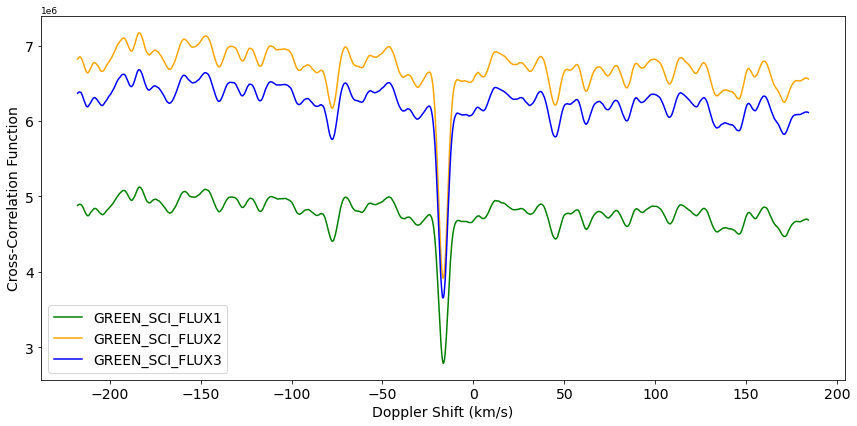

In [6]:
CCF_RV = L2['GREEN_CCF'].header['STARTV'] + \
         np.arange(L2['GREEN_CCF'].header['NAXIS1']) * L2['GREEN_CCF'].header['STEPV']
o = 18# order number
plt.figure(figsize=(12, 6), tight_layout=True)
plt.plot(CCF_RV, L2['GREEN_CCF'].data[0,o,:], color='g')
plt.plot(CCF_RV, L2['GREEN_CCF'].data[1,o,:], color='orange')
plt.plot(CCF_RV, L2['GREEN_CCF'].data[2,o,:], color='blue')
plt.legend(['GREEN_SCI_FLUX1', 'GREEN_SCI_FLUX2', 'GREEN_SCI_FLUX3'], fontsize=14, loc='best') 
plt.xlabel('Doppler Shift (km/s)', fontsize=14)
plt.ylabel('Cross-Correlation Function', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

Zoom in on the CCF peaks and mark the determined RVs for each slice

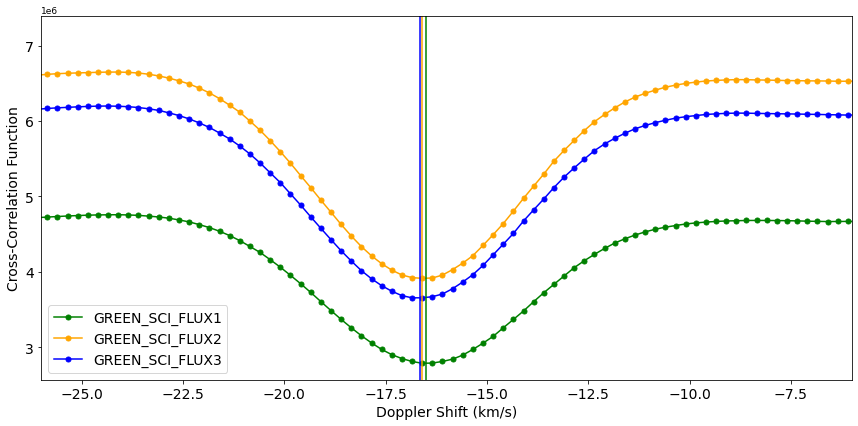

In [7]:
plt.figure(figsize=(12, 6), tight_layout=True)
plt.plot(CCF_RV, L2['GREEN_CCF'].data[0,o,:], '-o', color='g')
plt.plot(CCF_RV, L2['GREEN_CCF'].data[1,o,:], '-o', color='orange')
plt.plot(CCF_RV, L2['GREEN_CCF'].data[2,o,:], '-o', color='blue')
plt.axvline(x=L2['RV'].header['CCD1RV1'], color='g', label='CCD1RV1')
plt.axvline(x=L2['RV'].header['CCD1RV2'], color='orange', label='CCD1RV2')
plt.axvline(x=L2['RV'].header['CCD1RV3'], color='blue', label='CCD1RV3')
plt.legend(['GREEN_SCI_FLUX1', 'GREEN_SCI_FLUX2', 'GREEN_SCI_FLUX3'], fontsize=14, loc='best') 
plt.xlim(-26,-6)
plt.xlabel('Doppler Shift (km/s)', fontsize=14)
plt.ylabel('Cross-Correlation Function', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

# RVs
The RV extension is below.  Note that CCD1RV1, CCD1RV2, CCD1RV3 are the RVs for the three slices on the green CCD, while similar versions for CCD2 are for the Red CCD.

In [8]:
L2['RV'].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  133 / length of dimension 1                          
NAXIS2  =                   67 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                   14 / number of table fields                         
STAR_RV =              -16.597                                                  
CCD1ROW =                    0                                                  
CCD1RV1 =       -16.4964486965 / BaryC RV (km/s)                                
CCD1RV2 =       -16.5914246799 / BaryC RV (km/s)                                
CCD1RV3 =       -16.64570222

Here is the telemetry section, which will be incorporated into the next section.

In [9]:
df_rv = Table.read(L2_data_dir + ObsIDs[0] + '_L2.fits', format='fits',hdu='RV').to_pandas()
str_columns = ['source1', 'source2', 'source3']
for column in df_rv:
    if column in str_columns:
        df_rv[column] = df_rv[column].str.decode('utf-8')
df_rv

,orderlet1,orderlet2,orderlet3,s_wavelength,e_wavelength,segment no.,order no.,RV,RV error,CCFJD,Bary_RVC,source1,source2,source3
0,-14.667295,-14.370558,-14.580347,4505.883111,4465.447737,0,0,-14.522091,0.0,2.459955e+06,-27.447883,GREEN_SCI_FLUX1,GREEN_SCI_FLUX2,GREEN_SCI_FLUX3
1,-16.357935,-16.027360,-16.238453,4538.813663,4497.982847,1,1,-16.190784,0.0,2.459955e+06,-27.447883,GREEN_SCI_FLUX1,GREEN_SCI_FLUX2,GREEN_SCI_FLUX3
2,-15.785628,-15.401463,-15.253319,4572.585395,4531.223766,2,2,-15.456391,0.0,2.459955e+06,-27.447883,GREEN_SCI_FLUX1,GREEN_SCI_FLUX2,GREEN_SCI_FLUX3
3,-25.820058,-25.755219,-25.809710,4606.535466,4564.890307,3,3,-25.791927,0.0,2.459955e+06,-27.447883,GREEN_SCI_FLUX1,GREEN_SCI_FLUX2,GREEN_SCI_FLUX3
4,-16.496334,-16.625476,-16.675179,4641.171952,4599.291587,4,4,-16.608664,0.0,2.459955e+06,-27.447883,GREEN_SCI_FLUX1,GREEN_SCI_FLUX2,GREEN_SCI_FLUX3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62,0.000000,0.000000,0.000000,8226.205303,8151.111836,27,27,0.000000,0.0,2.459955e+06,-27.447848,RED_SCI_FLUX1,RED_SCI_FLUX2,RED_SCI_FLUX3
63,0.000000,0.000000,0.000000,8337.245583,8261.128164,28,28,0.000000,0.0,2.459955e+06,-27.447851,RED_SCI_FLUX1,RED_SCI_FLUX2,RED_SCI_FLUX3
64,0.000000,0.000000,0.000000,8451.799956,8374.624137,29,29,0.000000,0.0,2.459955e+06,-27.447854,RED_SCI_FLUX1,RED_SCI_FLUX2,RED_SCI_FLUX3
65,0.000000,0.000000,0.000000,8568.565099,8490.321120,30,30,0.000000,0.0,2.459955e+06,-27.447854,RED_SCI_FLUX1,RED_SCI_FLUX2,RED_SCI_FLUX3


# Create L3 file with time series RVs
The L3 file is a collection of RVs, state information and telemetry from a series of L2 files.  The example below builds the L3 file for the series of Tau Ceti observations and then displays ti.

In [10]:
rv_headers = ['JD', 
              'CCD1RV', 'CCD2RV', 
              'CCD1RV1', 'CCD1RV2', 'CCD1RV3', 
              'CCD2RV1', 'CCD2RV2', 'CCD2RV3', 
              'CCD1JD', 'CCD2JD']
headers = ['DATE-OBS', 'DATE-BEG', 'DATE-MID', 'DATE-END', 'UT', 
           'TEXP',
           'GREEN', 'RED', 'CA_HK', 'EXPMETER', 
           'TARGNAME', 'TELESCOP',
           'PROGNAME', 'OBSERVER', 'OBJECT', 'TARGNAME',
           'TARGRA', 'TARGDEC', 'RA', 'DEC', 
           'OCTAGON', 'FIUMODE', 'ADCTRACK', 'HCLSN',
           'SRCSHTTR', 'TIMSHTTR', 'OTIMSHTR', 
           'SCISEL', 'SKYSEL', 'FFSHTR', 'SCRAMSHT', 'SIMCALSH',
           'IMTYPE', 'CAL-OBJ', 'SKY-OBJ', 'SCI-OBJ',
           'CAFBS', 'EXPSCIFB', 'EXPSKYFB', 'FFFB', 'FICALFBS', 'SICALFB ', 'VACSCFB ', 'VACSKFB ', 'SCIFB', 'SKYFB',
           'GRACFFLN', 'RDACFFLN',
           'AGITSTA',
           'SSCALFW', 'SIMCALFW',
           'PRES', 'RELH', 
           'RABASE', 'DECBASE','RA', 'DEC', 'EL', 'AZ', 'LST', 'AXESTAT', 'GUIDING', 'AUTACTIV',
           'AUTFWHM',
           'SECFOCUS', 'TELFOCUS', 'TUBEFLEX', 'TUBETEMP', 'PRIMTEMP', 'SECMTEMP', 'DIFFPTDW', 'DIFFSTDW', 
           'VIGNETTE', 'STVIGNE', 'SBVIGNE', 'SBELEV', 'STELEV', 
          ]
headers_bool = ['GREEN', 'RED', 'CA_HK', 'EXPMETER'
                'CAFBS', 'EXPSCIFB', 'EXPSKYFB', 'FFFB', 'FICALFBS', 'SICALFB ', 'VACSCFB ', 'VACSKFB ', 'SCIFB', 'SKYFB',
                'AUTACTIV',
                'VIGNETTE', 'STVIGNE', 'SBVIGNE',
               ]
headers_time = ['DATE-OBS', 'DATE-BEG', 'DATE-MID', 'DATE-END']
headers_f64 = ['CCD1JD', 'CCD2JD']
all_columns  = ['obsID'] + rv_headers + headers

#To-do: add RV uncertainties, activity metrics, and additional telemetry (temperatures, etc.)

L3 = pd.DataFrame(columns=all_columns, index=range(1, len(ObsIDs)))
for i in range(len(ObsIDs)):
    L3.at[i,'obsID'] = ObsIDs[i]
    with fits.open(L2_data_dir + ObsIDs[i] + '_L2.fits') as L2:
        for h in headers:
            if h in headers_bool:
                if (L2['PRIMARY'].header[h] == 'YES') or (L2['PRIMARY'].header[h] == 'Yes') or (L2['PRIMARY'].header[h] == 'yes') or (L2['PRIMARY'].header[h] == 'true'):
                    L3.at[i,h] = True
                if (L2['PRIMARY'].header[h] == 'NO') or (L2['PRIMARY'].header[h] == 'No') or (L2['PRIMARY'].header[h] == 'no') or (L2['PRIMARY'].header[h] == 'false'):
                    L3.at[i,h] = False
            elif h in headers_time:
                L3.at[i,h] = Time(L2['PRIMARY'].header[h], format='isot', scale='utc')
            elif h == 'TEXP':
                (L3.at[0,'DATE-END'] - L3.at[0,'DATE-BEG']).sec
            else:
                L3.at[i,h] = L2['PRIMARY'].header[h]
        for h in rv_headers:
            if h == 'JD':
                if L3.at[i,'GREEN']:
                    L3.at[i,h] = np.float64(L2['RV'].header['CCD1JD'])
                if L3.at[i,'RED']:
                    L3.at[i,h] = np.float64(L2['RV'].header['CCD2JD'])
            elif h in headers_f64:
                L3.at[i,h] = np.float64(L2['RV'].header[h])
            else:
                L3.at[i,h] = L2['RV'].header[h]


In [11]:
L3 = L3.sort_values(by=['JD'])
L3

,obsID,JD,CCD1RV,CCD2RV,CCD1RV1,CCD1RV2,CCD1RV3,CCD2RV1,CCD2RV2,CCD2RV3,...,TUBETEMP,PRIMTEMP,SECMTEMP,DIFFPTDW,DIFFSTDW,VIGNETTE,STVIGNE,SBVIGNE,SBELEV,STELEV
0,KP.20230110.16623.72,2459954.692587,-16.585353,-16.728877,-16.496449,-16.591425,-16.645702,-17.185014,-16.277578,-16.914675,...,2.39,2.042575,2.169584,31.742575,31.769584,False,False,False,23.98,104.01
1,KP.20230110.16803.31,2459954.694665,-16.583159,-16.729211,-16.493994,-16.589117,-16.643846,-17.184929,-16.277798,-16.9152,...,2.38,2.019967,2.069626,31.919967,31.969626,False,False,False,23.98,104.01
2,KP.20230110.16986.84,2459954.696782,-16.584377,-16.728139,-16.495132,-16.590903,-16.644465,-17.183856,-16.277265,-16.913679,...,2.33,2.029319,1.991783,31.929319,31.891783,False,False,False,23.98,104.01
3,KP.20230110.17094.84,2459954.698035,-16.581968,-16.729253,-16.492783,-16.588338,-16.6422,-17.184946,-16.278056,-16.914516,...,2.34,2.020654,1.991783,31.620654,31.491783,False,False,False,23.98,104.01
4,KP.20230110.17186.85,2459954.699099,-16.584495,-16.729022,-16.495813,-16.590788,-16.644448,-17.18519,-16.2776,-16.91432,...,2.32,2.026085,1.982053,32.726085,32.682053,False,False,False,23.98,104.01
5,KP.20230110.17279.12,2459954.700168,-16.591628,-16.72818,-16.502983,-16.597813,-16.651663,-17.184077,-16.277782,-16.914636,...,2.29,2.029122,1.978515,33.029122,32.978515,False,False,False,23.98,104.01
6,KP.20230110.17371.41,2459954.701237,-16.590533,-16.728859,-16.501783,-16.596878,-16.650447,-17.185047,-16.278163,-16.915102,...,2.29,2.064939,1.89271,32.664939,32.49271,False,False,False,23.98,104.01
7,KP.20230110.17463.29,2459954.702299,-16.590101,-16.72839,-16.501853,-16.596208,-16.649906,-17.184939,-16.277577,-16.914709,...,2.29,2.029792,1.875903,32.929792,32.775903,False,False,False,23.98,104.01
8,KP.20230110.17580.34,2459954.703654,-16.583366,-16.72922,-16.494517,-16.589604,-16.643495,-17.184119,-16.27845,-16.914934,...,2.25,2.032434,1.855558,33.332434,33.155558,False,False,False,23.98,104.01
9,KP.20230110.17672.60,2459954.704722,-16.586729,-16.728562,-16.497864,-16.592944,-16.646888,-17.184767,-16.277349,-16.914209,...,2.25,2.028621,1.814867,32.828621,32.514867,False,False,False,23.98,104.01


Bin velocites in a p-mode time (323 seconds)

In [12]:
t_bin, CCD2RV_bin, CCD2ERRRV_bin = timebin((L3.JD - min(L3.JD))*24*60,
                                           (L3.CCD2RV - np.median(L3.CCD2RV))*1000*100,
                                           (L3.CCD2RV - np.median(L3.CCD2RV))*0+1,
                                           323/60)

# Plot KPF RV time series

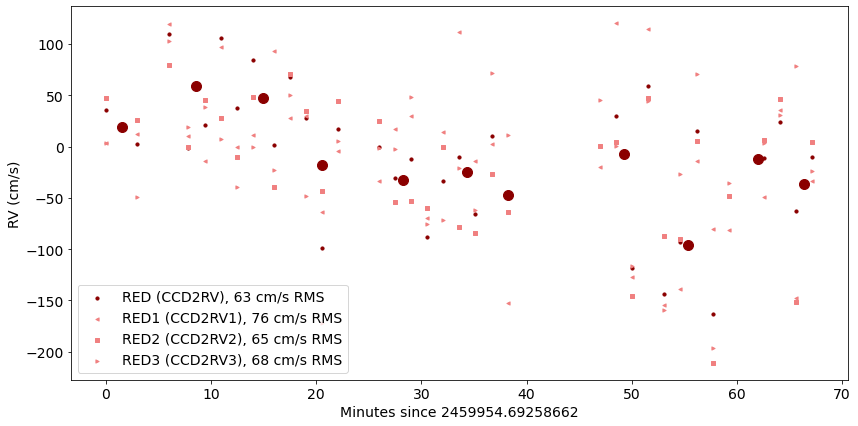

In [13]:
L3old = L3
L3=L3old.where(L3old.CCD2RV2 < 100)
plt.figure(figsize=(12, 6), tight_layout=True)
plt.plot()
plt.scatter((L3.JD - min(L3.JD))*24*60, 
            (L3.CCD2RV - np.median(L3.CCD2RV))*1000*100, 
            marker="o", color='darkred', s=10)
plt.scatter((L3.JD - min(L3.JD))*24*60, 
            (L3.CCD2RV1 - np.median(L3.CCD2RV1))*1000*100, 
            marker="<", color='lightcoral', s=10)
plt.scatter((L3.JD - min(L3.JD))*24*60, 
            (L3.CCD2RV2 - np.median(L3.CCD2RV2))*1000*100, 
            marker="s", color='lightcoral', s=10)
plt.scatter((L3.JD - min(L3.JD))*24*60, 
            (L3.CCD2RV3 - np.median(L3.CCD2RV3))*1000*100, 
            marker=">", color='lightcoral', s=10)
plt.scatter(t_bin, 
            CCD2RV_bin, 
            marker="o", color='darkred', s=100)
plt.legend([
            'RED (CCD2RV), '   + str(int(np.std(L3.CCD2RV*1000*100)))  + ' cm/s RMS',
            'RED1 (CCD2RV1), ' + str(int(np.std(L3.CCD2RV1*1000*100))) + ' cm/s RMS', 
            'RED2 (CCD2RV2), ' + str(int(np.std(L3.CCD2RV2*1000*100))) + ' cm/s RMS', 
            'RED3 (CCD2RV3), ' + str(int(np.std(L3.CCD2RV3*1000*100))) + ' cm/s RMS',
           ], fontsize=14, loc='best') 
plt.xlabel('Minutes since ' + str(min(L3.JD)), fontsize=14)
plt.ylabel('RV (cm/s)', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

Same thinge for Green CCD, which currently has problems with the wavelength solution for certain orders.

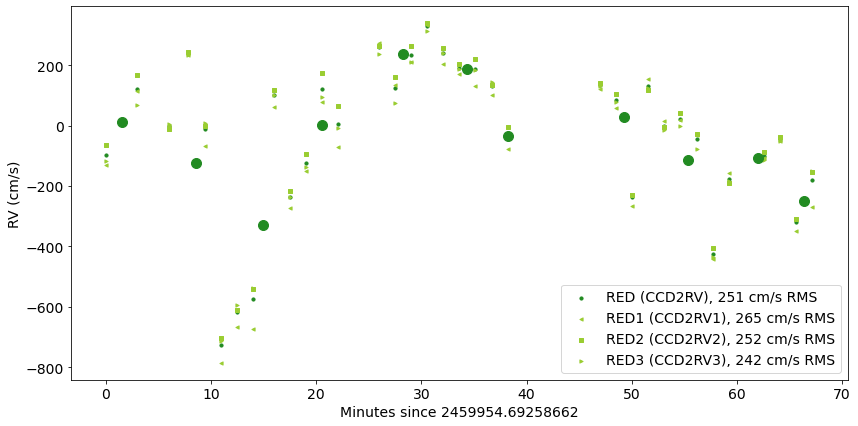

In [14]:
t_bin, CCD1RV_bin, CCD1ERRRV_bin = timebin((L3.JD - min(L3.JD))*24*60,
                                           (L3.CCD1RV - np.median(L3.CCD1RV))*1000*100,
                                           (L3.CCD1RV - np.median(L3.CCD1RV))*0+1,
                                           323/60)

L3old = L3
#L3=L3old.where(L3old.CCD1RV2 < 100)
plt.figure(figsize=(12, 6), tight_layout=True)
plt.plot()
plt.scatter((L3.JD - min(L3.JD))*24*60, 
            (L3.CCD1RV - np.median(L3.CCD1RV))*1000*100, 
            marker="o", color='forestgreen', s=10)
plt.scatter((L3.JD - min(L3.JD))*24*60, 
            (L3.CCD1RV1 - np.median(L3.CCD1RV1))*1000*100, 
            marker="<", color='yellowgreen', s=10)
plt.scatter((L3.JD - min(L3.JD))*24*60, 
            (L3.CCD1RV2 - np.median(L3.CCD1RV2))*1000*100, 
            marker="s", color='yellowgreen', s=10)
plt.scatter((L3.JD - min(L3.JD))*24*60, 
            (L3.CCD1RV3 - np.median(L3.CCD1RV3))*1000*100, 
            marker=">", color='yellowgreen', s=10)
plt.scatter(t_bin, 
            CCD1RV_bin, 
            marker="o", color='forestgreen', s=100)
plt.legend([
            'RED (CCD2RV), '   + str(int(np.std(L3.CCD1RV*1000*100)))  + ' cm/s RMS',
            'RED1 (CCD2RV1), ' + str(int(np.std(L3.CCD1RV1*1000*100))) + ' cm/s RMS', 
            'RED2 (CCD2RV2), ' + str(int(np.std(L3.CCD1RV2*1000*100))) + ' cm/s RMS', 
            'RED3 (CCD2RV3), ' + str(int(np.std(L3.CCD1RV3*1000*100))) + ' cm/s RMS',
           ], fontsize=14, loc='best') 
plt.xlabel('Minutes since ' + str(min(L3.JD)), fontsize=14)
plt.ylabel('RV (cm/s)', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()